<a href="https://colab.research.google.com/github/ITALOZDKJ/Me-tornando-um-analista-de-dados/blob/main/Comparativo_de_investimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importando bibliotecas

In [1]:
!pip install yfinance
import pandas as pd
import numpy as np
import pandas_datareader as web
import yfinance as yf
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt


     |████████████████████████████████| 6.4 MB 10.9 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


# Criando funções

### A seguir, temos uma função que cria features mais básicas, partindo das já disponíveis nos dados importados.

In [103]:
def features_initial(x):
    x.reset_index(inplace=True)
    x['Day'] = x['Date'].dt.day
    x['Month'] = x['Date'].dt.month
    x['Year'] = x['Date'].dt.year
    x['Year-Month'] = x['Date'].dt.strftime('%Y') +'-' + x['Date'].dt.strftime('%m') 
    x['Rentability%'] = round((x['Close']/x['Close'].shift()) * 100 -100, 2)
    x['Rentability pure'] = round(x['Close'] - x['Close'].shift(),2)

### Já a função abaixo, cria features um pouco mais elaboradas, nos permitindo simular um investimento feito de forma mensal e consistente, no período dos dados extraídos.

Com ela, conseguiremos informações como a quantidade de cotas totais em cada período, dividendos totais recebidos,
total de patrimônio acumuldado considerando a valorização do ativo e os dividendos recebidos ao longo do tempo.

In [104]:
def features_cash(x, y, aporte=100):
    x['Action_value'] = (x.loc[:,'High']+ x.loc[:,'Low'])/2
    year_temp = 0
    # 
    for year in list(x['Year'].unique()):
        year_temp = x.loc[(x['Year']==year)]
        for month in list(year_temp['Month'].unique()):
            temp = x.loc[(x['Month'] == month) & (x['Year']==year)]
            day = list(temp[0:]['Day'])
            day = day[0]
            x.loc[(x['Day'] == day) & (x['Month'] == month) & (x['Year'] == year),['Bougth']] = aporte
    # Valor de aporte
    x.loc[:,'Valor_aportado'] = x['Bougth'] * x['Action_value']
    x.fillna(0, inplace=True)
    # A soma das ações
    x['Total_actions'] = 0
    for pos,c in enumerate(x['Bougth']):
        x.loc[pos,'Total_actions'] = x.loc[:pos,'Bougth'].sum()
    
    # A soma do valor investido 
    x['Total_aportado'] = 0
    for pos,c in enumerate(x['Total_actions']):
        x.loc[pos,'Total_aportado'] = x.loc[:pos,'Valor_aportado'].sum()
        
    # The sum of dividends receives with actual aports
    x['Dividend_receive'] = x['Total_actions'] * x['Dividends']
    
    # The final dividends receives
    x['Total_receive'] = 0
    for pos,c in enumerate(x['Dividend_receive']):
        x.loc[pos,'Total_receive'] = x.loc[:pos,'Dividend_receive'].sum()

    x['Valor_atual'] = x['Total_actions'] * x['Close']


    x['My_rentability_pure'] = round(x['Valor_atual'] - x['Valor_atual'].shift(),2)

    x['yld_final'] = (x['Total_receive']/x['Total_aportado'])*100

def soma(x):
  x['Acumulatted'] = x['Valor_atual'] + x['Total_receive'] + x['Rentability pure']

## Importação de dados e aplicação das funções nos conjuntos de dados

In [105]:
ticket = yf.Ticker('TAEE4.SA')
bbseguros = yf.Ticker('BBSE3.SA')
itsa = yf.Ticker('ITSA4.SA')

In [106]:
taesa = ticket.history(interval='1d',start='2017-04-25', end='2022-04-25')
bbseguros = bbseguros.history(interval='1d',start='2017-04-25', end='2022-04-25')
itsa = itsa.history(interval='1d', start = '2017-04-25', end = '2022-04-25')

In [107]:
taesa_a = taesa.copy()
bbseguros_a = bbseguros.copy()
itsa_a = itsa.copy()
features_initial(taesa_a)
features_initial(bbseguros_a)
features_initial(itsa_a)

In [108]:
features_cash(bbseguros_a, bbseguros, aporte = 10)
features_cash(taesa_a, taesa, aporte=10)
features_cash(itsa_a, itsa, aporte=10)

In [109]:
soma(taesa_a)
soma(bbseguros_a)
soma(itsa_a)

In [110]:
taesa_a[['Close','Rentability%', 'Total_aportado', 'My_rentability_pure', 'Valor_atual', 'Total_actions', 'Total_receive', 'Acumulatted', 'yld_final']].tail()

,Close,Rentability%,Total_aportado,My_rentability_pure,Valor_atual,Total_actions,Total_receive,Acumulatted,yld_final
1228,14.80,0.27,4623.810647,24.0,8880.000114,600,1552.88341,10432.923524,33.584494
1229,14.78,-0.14,4623.810647,-12.0,8867.999840,600,1552.88341,10420.863250,33.584494
1230,14.83,0.34,4623.810647,30.0,8897.999954,600,1552.88341,10450.933364,33.584494
1231,14.85,0.13,4623.810647,12.0,8910.000229,600,1552.88341,10462.903639,33.584494
1232,14.79,-0.40,4623.810647,-36.0,8873.999977,600,1552.88341,10426.823387,33.584494


Text(0, 0.5, 'Acumulado')

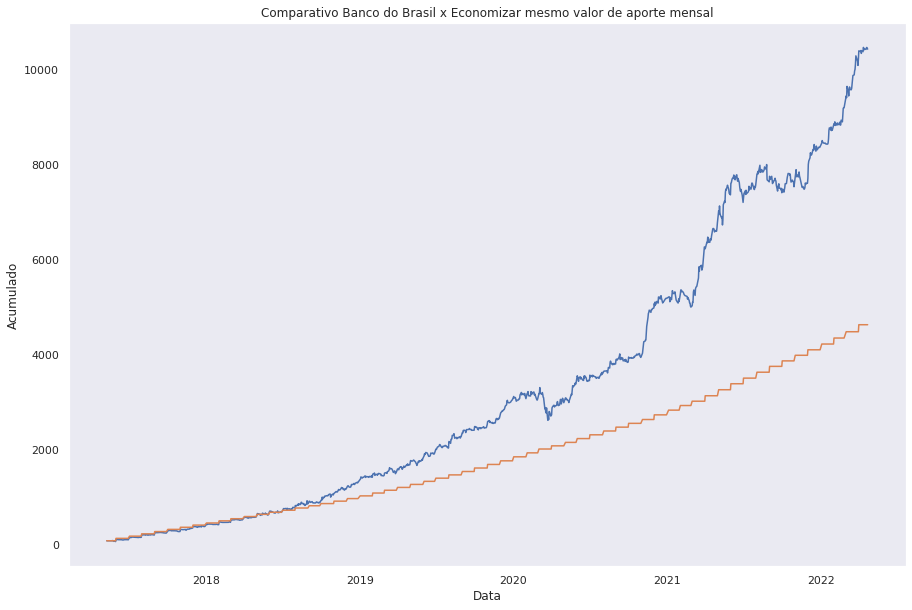

In [118]:
plt.figure(figsize=(15,10))
sns.set_theme(style="dark")
sns.lineplot(data = taesa_a, x='Date', y='Acumulatted')
sns.lineplot(data = taesa_a, x='Date', y='Total_aportado')
plt.title('Comparativo Banco do Brasil x Economizar mesmo valor de aporte mensal')
plt.xlabel('Data')
plt.ylabel('Acumulado')

In [121]:
taesa_a['Rentability%'].sum()

87.2

In [11]:
taesa_a['Rentability%'].sum()

87.2

In [12]:
bbseguros_a[['Close','Rentability%', 'Total_aportado', 'My_rentability_pure', 'Valor_atual', 'Total_actions', 'Total_receive', 'Acumulatted', 'yld_final']].tail()

,Close,Rentability%,Total_aportado,My_rentability_pure,Valor_atual,Total_actions,Total_receive,Acumulatted,yld_final
1238,26.160000,0.85,13659.376133,134.2,15957.599907,610,3516.82346,19474.643367,25.746589
1239,26.780001,2.37,13659.376133,378.2,16335.800419,610,3516.82346,19853.243879,25.746589
1240,26.020000,-2.84,13659.376133,-463.6,15872.200279,610,3516.82346,19388.263739,25.746589
1241,26.760000,2.84,13659.376133,451.4,16323.600140,610,3516.82346,19841.163600,25.746589
1242,26.389999,-1.38,13659.376133,-225.7,16097.899628,610,3516.82346,19614.353088,25.746589


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0, 0.5, 'Acumulado')

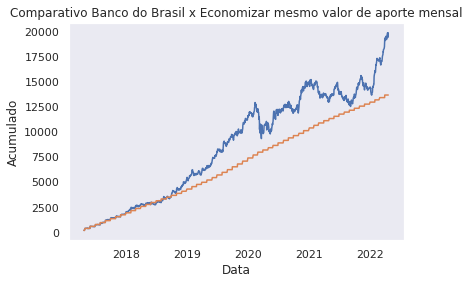

In [32]:
sns.set_theme(style="dark")
sns.lineplot(data = bbseguros_a, x='Date', y='Acumulatted')
sns.lineplot(data = bbseguros_a, x='Date', y='Total_aportado')
plt.title('Comparativo Banco do Brasil x Economizar mesmo valor de aporte mensal')
plt.xlabel('Data')
plt.ylabel('Acumulado')

In [14]:
bbseguros_a['Rentability%'].sum()

49.099999999999994

In [15]:
itsa_a[['Close','Rentability%', 'Total_aportado', 'My_rentability_pure', 'Valor_atual', 'Total_actions', 'Total_receive', 'Acumulatted', 'yld_final']].tail()

,Close,Rentability%,Total_aportado,My_rentability_pure,Valor_atual,Total_actions,Total_receive,Acumulatted,yld_final
1239,10.10,0.10,5421.471186,6.1,6161.000233,610,901.54024,7062.550473,16.62907
1240,10.16,0.59,5421.471186,36.6,6197.599907,610,901.54024,7099.200147,16.62907
1241,10.05,-1.08,5421.471186,-67.1,6130.500116,610,901.54024,7031.930356,16.62907
1242,10.06,0.10,5421.471186,6.1,6136.600256,610,901.54024,7038.150496,16.62907
1243,9.91,-1.49,5421.471186,-91.5,6045.099907,610,901.54024,6946.490147,16.62907


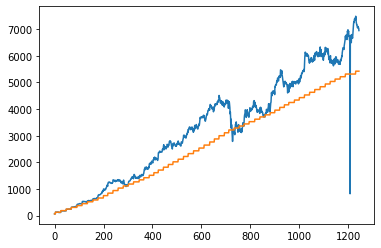

In [16]:
itsa_a['Acumulatted'].plot(kind='line')
itsa_a['Total_aportado'].plot(kind='line')

In [17]:
itsa_a['Rentability%'].sum()

69.15999999999998

In [18]:
itsa_a.head(1)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Day,Month,...,Bougth,Valor_aportado,Total_actions,Total_aportado,Dividend_receive,Total_receive,Valor_atual,My_rentability_pure,yld_final,Acumulatted
0,2017-04-25,6.252382,6.317784,6.226222,6.311243,15940848.0,0.0,0.0,25,4,...,10.0,62.720025,10,62.720025,0.0,0.0,63.112431,NaN,0.0,63.112431


In [93]:
teste = taesa_a

In [101]:
x['Mes-ano'] = x['Date'].dt.strftime('%Y') +'-' + x['Date'].dt.strftime('%m') 

In [102]:
teste['Mes-ano']

0       2017-05
1       2017-05
2       2017-05
3       2017-05
4       2017-05
         ...   
1228    2022-04
1229    2022-04
1230    2022-04
1231    2022-04
1232    2022-04
Name: Mes-ano, Length: 1233, dtype: object